## Project 3

This is a collaborative project conducted by the Fall 2017 students of DATA 620 at The City University of New York, in partial fulfillment of the requirements for the MS in Data Science degree.

### Problem Description

This is a Team Project! For this project, please work with the entire class as one collaborative group! Your project should be submitted (as an IPython Notebook via GitHub) by end of day on Monday, October 25th. The group should present their code and findings in our meet-up on Tuesday October 26th. The ability to be an effective member of a virtual team is highly valued in the data science job market.
Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

Source: Natural Language Processing with Python, exercise 6.10.2.

### Contributors Include

* Joy Payton
* Keith Folsom


### First, Obtain the Corpus

Note: If not already executed, nltk.download() will allow you access to the names corpus

In [750]:
import nltk
from nltk.corpus import names
import random
import numpy
import pandas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import itertools

import re
import operator
import string
from textstat.textstat import textstat

nltk.download('names')

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Derek\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [696]:
# set display digits
display_digits=4


# inline matplotlib
%matplotlib inline

In [557]:
names = ([(name, 'male') for name in names.words('male.txt')] + \
         [(name, 'female') for name in names.words('female.txt')])

In [558]:
random_seed=1534678
random.seed(random_seed)
random.shuffle(names)

# let's see what the randomly shuffles names look like
names[1:10]

[(u'Edmund', 'male'),
 (u'Cariotta', 'female'),
 (u'Theresina', 'female'),
 (u'Mimi', 'female'),
 (u'Alecia', 'female'),
 (u'Jillayne', 'female'),
 (u'Godiva', 'female'),
 (u'Jeniffer', 'female'),
 (u'Tersina', 'female')]

### Create three subsets for development and error analysis of the models.

##### Development set:
* 6900 names for the training set
* 500 names for the dev-test set  

##### Test set:
* 500 names for the testing set

In [559]:
test_names, devtest_names, train_names = names[0:500], names[500:1000], names[1000:]

In [560]:
# Confirm the size of the three subsets
print("Training Set = {}".format(len(train_names)))
print("Dev-Test Set = {}".format(len(devtest_names)))
print("Test Set = {}".format(len(test_names)))

Training Set = 6944
Dev-Test Set = 500
Test Set = 500


We can see the the distribution of females and males in our training set as follows:

In [843]:
train_set_gold = [g  for (n, g) in train_names]
nltk.FreqDist(train_set_gold)

FreqDist({'female': 4348, 'male': 2596})

### Feature Extractor Functions

This section below is to incrementallly improve the feature extraction functions which are subsequently applied to the development and test datasets.

In [751]:
# book example
def gender_features(name):
    return {'lastletter': name[-1].lower()}

# most names beginning with a vowel are associated with females
def gender_features2(name):
    return {'firstletter': name[0].lower()}

# from the book feature extractor that overfits 
def gender_features3(name):
    features = {}
    features["firstletter"] = name[0].lower()
    features["lastletter"] = name[-1].lower()
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features["count(%s)" % letter] = name.lower().count(letter)
        features["has(%s)" % letter] = (letter in name.lower())
    return features

## from the book
def gender_features4(name):
    return {"lastletter": name[-1:].lower(), "last2letter": name[-2:].lower()}

def gender_features5(name):
    return {'length': len(name)}

def gender_features6(name):
    features = {}
    letters=list(map(chr, range(ord('a'), ord('z') + 1)))
    for letter in letters:
        features["count(%s)" % letter] = name.lower().count(letter)
    return features

## from the book
def gender_features7(name):
    return {"last3letter": name[-3:].lower()}

def gender_features8(name):
    features = {}
    letters=list(map(chr, range(ord('a'), ord('z') + 1)))
    for letter1 in letters:
        for letter2 in letters:
            features["has("+letter1+letter2+")"] = (letter1+letter2 in name.lower())
    return features

def gender_features9(name):
    return {"first2Letters": name[0:2].lower()}

def gender_features10(name):
    features = {}
    features["firstletter"] = name[0].lower()
    features["lastletter"] = name[-1].lower()
    features["last2letter"] = name[-2:].lower()
    features["last3letter"] = name[-3:].lower()
            
    letters=list(map(chr, range(ord('a'), ord('z') + 1)))
    for letter1 in letters:
        features["count("+letter1+")"] = name.lower().count(letter1)
        features["has("+letter1+")"] = (letter1 in name.lower())
        # iterate over 2-grams
        for letter2 in letters:
            
            features["has("+letter1+letter2+")"] = (letter1+letter2 in name.lower())
            
    return features

def best_gender_features(name):
    # define features
    features = {}
    # has(fo) = True
    features["has(fo)"] = ('fo' in name.lower())
    # has(hu) = True
    features["has(hu)"] = ('hu' in name.lower())
    # has(rv) = True
    features["has(rv)"] = ('rv' in name.lower())    
    # has(rw) = True
    features["has(rw)"] = ('rw' in name.lower()) 
    # has(sp) = True
    features["has(sp)"] = ('sp' in name.lower())
    
    # lastletter = 'a'
    features["lastletter=a"] = ('a' in name[-1:].lower())
    # lastletter = 'f'
    features["lastletter=f"] = ('f' in name[-1:].lower())
    # lastletter = 'k'
    features["lastletter=k"] = ('k' in name[-1:].lower())
    
    # last2letter = 'ch'
    features["last2letter=ch"] = ('ch' in name[-2:].lower())
    # last2letter = 'do'
    features["last2letter=do"] = ('do' in name[-2:].lower())
    # last2letter = 'ia'
    features["last2letter=ia"] = ('ia' in name[-2:].lower())
    # last2letter = 'im'
    features["last2letter=im"] = ('im' in name[-2:].lower())
    # last2letter = 'io'
    features["last2letter=io"] = ('io' in name[-2:].lower())
    # last2letter = 'la'
    features["last2letter=la"] = ('la' in name[-2:].lower())
    # last2letter = 'ld'
    features["last2letter=ld"] = ('ld' in name[-2:].lower())
    # last2letter = 'na'
    features["last2letter=na"] = ('na' in name[-2:].lower())
    # last2letter = 'os'
    features["last2letter=os"] = ('os' in name[-2:].lower())
    # last2letter = 'ra'
    features["last2letter=ra"] = ('ra' in name[-2:].lower())
    # last2letter = 'rd'
    features["last2letter=rd"] = ('rd' in name[-2:].lower())
    # last2letter = 'rt'
    features["last2letter=rt"] = ('rt' in name[-2:].lower())
    # last2letter = 'sa'
    features["last2letter=sa"] = ('sa' in name[-2:].lower())
    # last2letter = 'ta'
    features["last2letter=ta"] = ('ta' in name[-2:].lower())
    # last2letter = 'us'
    features["last2letter=us"] = ('us' in name[-2:].lower())
    
    # last3letter = 'ana'
    features["last3letter=ana"] = ('ana' in name[-3:].lower())    
    # last3letter = u'ard'
    features["last3letter=ard"] = ('ard' in name[-3:].lower())        
    # last3letter = u'ita'
    features["last3letter=ita"] = ('ita' in name[-3:].lower())    
    # last3letter = u'nne'
    features["last3letter=nne"] = ('nne' in name[-3:].lower())    
    # last3letter = u'tta'
    features["last3letter=tta"] = ('tta' in name[-3:].lower())    
    
    return features

def gender_features11(name):
    # define features
    features = {}    
    # vowel counts
    features['vowel_count'] = len(re.sub(r'[^aeiou]', '', name.lower()))
    
    return features

def gender_features12(name):
    # define features
    features = {}    
    # hard consonants using general rules of c and g
    features['hard_consts'] = len(re.findall(r'[cg][^eiy]', name.lower()))/2

    return features

def gender_features13(name):
    # define features
    features = {}    
    # soft consonants using general rules of c and g
    features['soft_consts'] = len(re.findall(r'[cg][eiy]', name.lower()))/2
    
    return features

def gender_features14(name):
    # define features
    features = {}
    # syllable Count of names via textstat
    features['syllable_count'] = textstat.syllable_count(name.lower())    
    return features


In [711]:
def normalize_confusion_matrix(cm):
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    # return confusion matrix
    return cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. Set `normalize=True` for normalization.
    """
    if normalize:
        cm = normalize_confusion_matrix(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    return

def plot_both_confusion_matrix(cm,label_names):
    # size figure
    plt.figure(figsize=(10,6))
    # add first subplot
    plt.subplot(2, 2, 1)
    # plot confusion matrix
    plot_confusion_matrix(cm,classes=label_names,normalize=False)
    # add second subplot
    plt.subplot(2, 2, 2)
    # plot confusion matrix (normalized)
    plot_confusion_matrix(cm,classes=label_names,normalize=True)
    
    return

def evaluate_naive_bayes_classifier(train_names,devtest_names,test_names,f):
    # create feature set (train)
    train_set = [(f(n), g)  for (n, g) in train_names]
    # create feature set (dev test)
    devtest_set = [(f(n), g)  for (n, g) in devtest_names]
    # create test set (dev test)
    test_set = [(f(n), g)  for (n, g) in test_names]
    # build classifier
    classifier = nltk.NaiveBayesClassifier.train(train_set) 
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_set)
    # compute accuracy (development test set)
    devtest_accuracy=nltk.classify.accuracy(classifier, devtest_set)
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(f(n))  for (n, g) in train_names]
    # extract actual classes (gold)
    train_set_gold = [g  for (n, g) in train_names]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (dev test)
    devtest_set_predictions = [classifier.classify(f(n))  for (n, g) in devtest_names]
    # extract actual classes (gold)
    devtest_set_gold = [g  for (n, g) in devtest_names]
    # create confusion matrix (dev test)
    devtest_cm=confusion_matrix(devtest_set_gold, devtest_set_predictions)
    # get unique classes (dev test)
    devtest_label_names =  list(set(devtest_set_gold) | set(devtest_set_predictions))
    # create table with precision, recall, f1-score, and support
    devtest_report=classification_report(devtest_set_gold, devtest_set_predictions,
        digits=display_digits)

    return train_accuracy,train_cm,train_label_names,train_report,devtest_accuracy,devtest_cm,devtest_label_names,devtest_report,classifier

def evaluate_decision_tree_classifier(train_names,devtest_names,test_names,f):
    # create feature set (train)
    train_set = [(f(n), g)  for (n, g) in train_names]
    # create feature set (dev test)
    devtest_set = [(f(n), g)  for (n, g) in devtest_names]
    # create test set (dev test)
    test_set = [(f(n), g)  for (n, g) in test_names]
    # build classifier
    classifier = nltk.DecisionTreeClassifier.train(train_set)
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_set)
    # compute accuracy (development test set)
    devtest_accuracy=nltk.classify.accuracy(classifier, devtest_set)
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(f(n))  for (n, g) in train_names]
    # extract actual classes (gold)
    train_set_gold = [g  for (n, g) in train_names]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (dev test)
    devtest_set_predictions = [classifier.classify(f(n))  for (n, g) in devtest_names]
    # extract actual classes (gold)
    devtest_set_gold = [g  for (n, g) in devtest_names]
    # create confusion matrix (dev test)
    devtest_cm=confusion_matrix(devtest_set_gold, devtest_set_predictions)
    # get unique classes (dev test)
    devtest_label_names =  list(set(devtest_set_gold) | set(devtest_set_predictions))
    # create table with precision, recall, f1-score, and support
    devtest_report=classification_report(devtest_set_gold, devtest_set_predictions,
        digits=display_digits)

    return train_accuracy,train_cm,train_label_names,train_report,devtest_accuracy,devtest_cm,devtest_label_names,devtest_report,classifier
    

### Features Exploration

In the following section, we briefly explore the conditional frequency distributions of a subset of our feature set generation rules by gender.

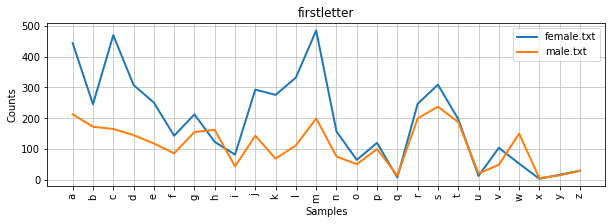

In [837]:
# firstletter
cfd_firstletter = nltk.ConditionalFreqDist((gender, name[0].lower()) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='firstletter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_firstletter.plot()


We observe many more female names beginning with 'a', 'c', and 'm'.

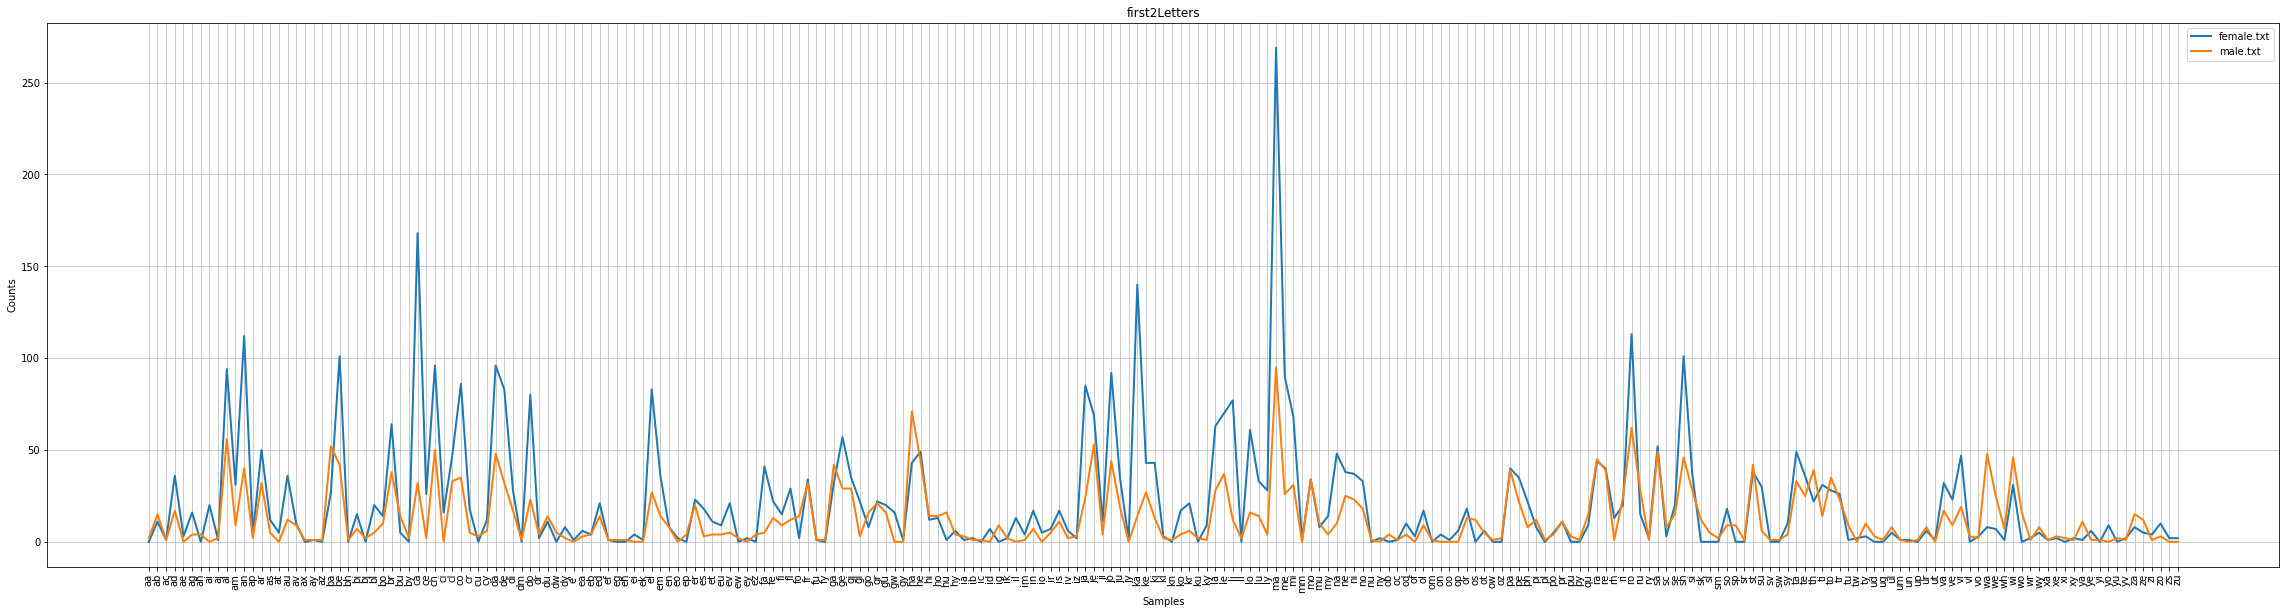

In [814]:
# first2Letters
cfd_first2Letters = nltk.ConditionalFreqDist((gender, name[0:2].lower()) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='first2Letters'

# set figure size
plt.figure(figsize=(40,10))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_first2Letters.plot()


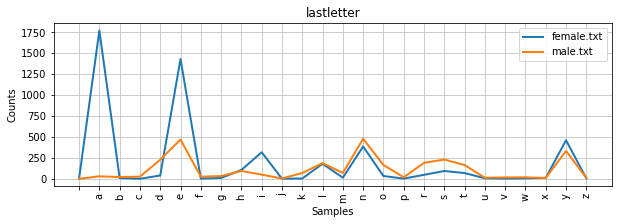

In [810]:
# lastletter
cfd_lastletter = nltk.ConditionalFreqDist((gender, name[-1].lower()) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='lastletter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_lastletter.plot()

Names ending in the letters, 'a', 'e', or 'i' tend to be female, while the names ending in 's' are a bit more likely to be male.

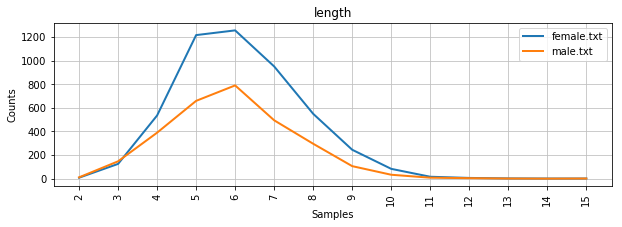

In [817]:
# length
cfd_length = nltk.ConditionalFreqDist((gender, len(name)) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='length'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_length.plot()

We can see (immediately above) that the the distributions of name length for female and male names are roughly the same shape and thus we would not expect our model to gain much predictive power from this feature set.

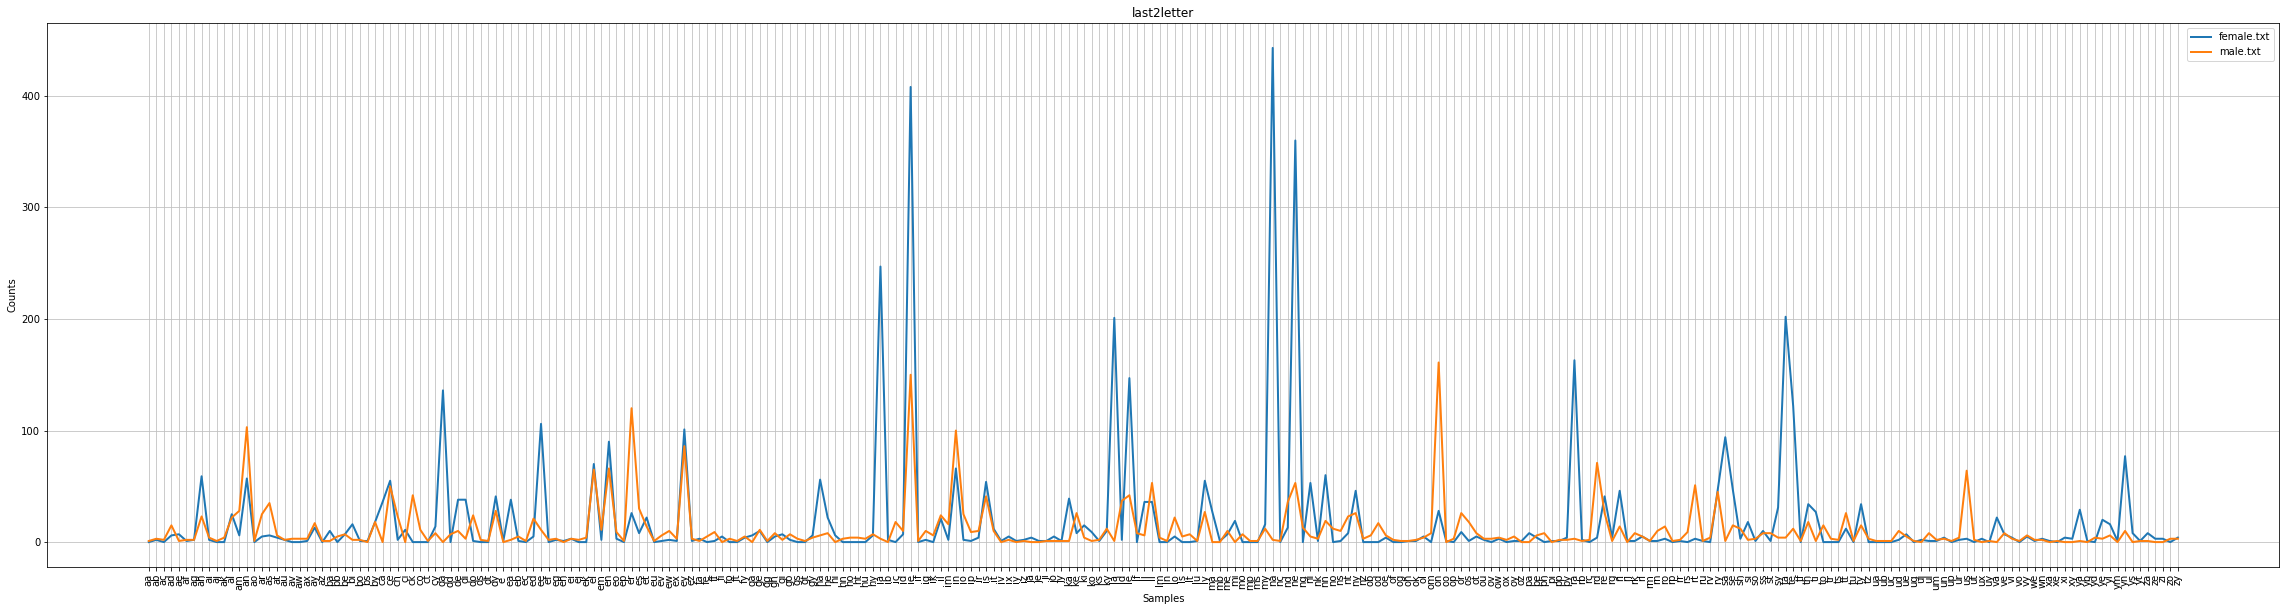

In [832]:
# last2letter
cfd_last2letter = nltk.ConditionalFreqDist((gender, name[-2:].lower()) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='last2letter'

# set figure size
plt.figure(figsize=(40,10))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_last2letter.plot()

In [831]:
#cfd_last2letter.tabulate()

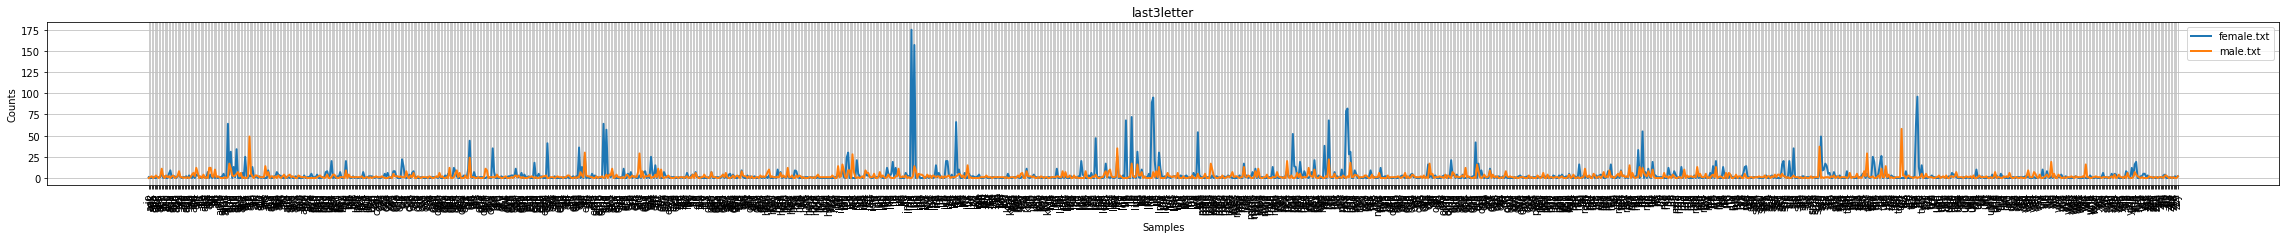

In [825]:
# last3letter
cfd_last3letter = nltk.ConditionalFreqDist((gender, name[-3:].lower()) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='last3letter'

# set figure size
plt.figure(figsize=(40,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_last3letter.plot()

In [830]:
#cfd_last3letter.tabulate()

Examining with 50 most important features...

### Helper Functions

In [563]:
# Generic function to generate an error list based the arguments provided
# Accepts the classifer, names dataset, and the extractor function
# Returns the list of errors

def generate_errors(classifier, dataset, extractor_function): 
    
    errors = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(extractor_function(name)) 
        if guess != tag: 
            errors.append((tag, guess, name))
            
    return errors

In [564]:
def generate_prediction(classifier, dataset, extractor_function): 
    
    classification = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(extractor_function(name)) 
        classification.append((name,guess))
            
    return classification

In [565]:
# Generic function to display classification errors
# Accepts the error list and an optional argument to show only n number of errors

def show_errors(errors, n=None):
   
    if n is not None: errors = errors[:n]
            
    for (tag, guess, name) in sorted(errors): 
        print('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))

### Gender Identification Models (Try Some Models)

#### Gender Classification Model 1

In this model, we train a Naive Bayes classifier using a simple feature set - namely the last letter of the name. In our brief exploration of features, we observed some patterns that could likely be exploited by our classifier.

Accuracy (Train): 0.760512672811
Accuracy (Development Test): 0.762


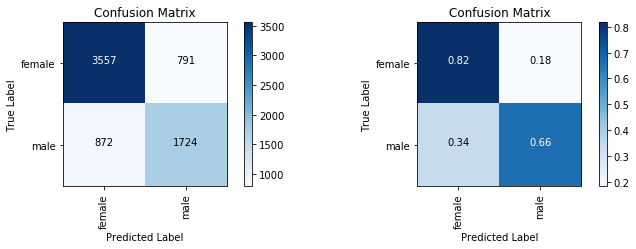

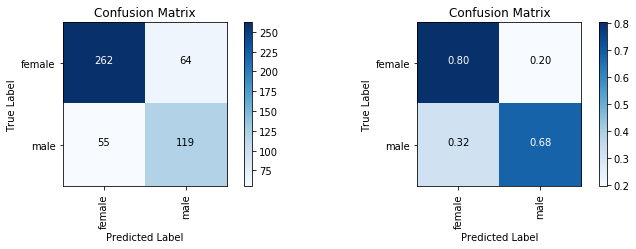

In [846]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb0,train_cm_nb0,train_label_names_nb0,train_report_nb0, \
    devtest_accuracy_nb0, devtest_cm_nb0,devtest_label_names_nb0, \
    devtest_report_nb0, classifier_nb0=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb0))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb0))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb0,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb0,['female','male'])

['male', 'female']

In [715]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb0)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb0)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8031    0.8181    0.8105      4348
       male     0.6855    0.6641    0.6746      2596

avg / total     0.7591    0.7605    0.7597      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8265    0.8037    0.8149       326
       male     0.6503    0.6839    0.6667       174

avg / total     0.7652    0.7620    0.7633       500



In [839]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb0.show_most_informative_features(n_informative_features)

Most Informative Features
              lastletter = u'k'             male : female =     39.8 : 1.0
              lastletter = u'a'           female : male   =     32.2 : 1.0
              lastletter = u'f'             male : female =     15.0 : 1.0
              lastletter = u'v'             male : female =     11.0 : 1.0
              lastletter = u'm'             male : female =      9.8 : 1.0
              lastletter = u'd'             male : female =      9.8 : 1.0
              lastletter = u'p'             male : female =      9.7 : 1.0
              lastletter = u'o'             male : female =      8.2 : 1.0
              lastletter = u'r'             male : female =      6.6 : 1.0
              lastletter = u'g'             male : female =      5.6 : 1.0
              lastletter = u'w'             male : female =      5.0 : 1.0
              lastletter = u'z'             male : female =      4.5 : 1.0
              lastletter = u's'             male : female =      4.2 : 1.0

Although names ending in the letter 'a' is our second best feature in this feature set, the other rules that looked useful in gender prediction were not in the top of the list.

This is perhaps because we explored the conditional frequency, rather than the percent conditional frequency.

#### Gender Classification Model 2

In this model, we train a Naive Bayes classifier using the first letter of the name.

Accuracy (Train): 0.646745391705
Accuracy (Development Test): 0.656


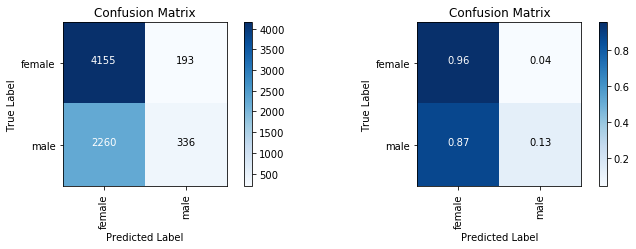

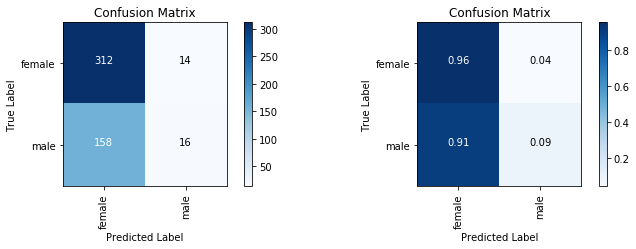

In [847]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb2,train_cm_nb2,train_label_names_nb2,train_report_nb2, \
    devtest_accuracy_nb2, devtest_cm_nb2,devtest_label_names_nb2, \
    devtest_report_nb2, classifier_nb2=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features2)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb2))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb2))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb2,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb2,['female','male'])

In [720]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb2)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb2)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6477    0.9556    0.7721      4348
       male     0.6352    0.1294    0.2150      2596

avg / total     0.6430    0.6467    0.5638      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6638    0.9571    0.7839       326
       male     0.5333    0.0920    0.1569       174

avg / total     0.6184    0.6560    0.5657       500



In [721]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb2.show_most_informative_features(n_informative_features)

Most Informative Features
             firstletter = u'W'             male : female =      4.8 : 1.0
             firstletter = u'Q'             male : female =      2.5 : 1.0
             firstletter = u'X'             male : female =      2.4 : 1.0
             firstletter = u'K'           female : male   =      2.3 : 1.0
             firstletter = u'U'             male : female =      2.3 : 1.0
             firstletter = u'H'             male : female =      2.3 : 1.0
             firstletter = u'Y'             male : female =      1.9 : 1.0
             firstletter = u'L'           female : male   =      1.7 : 1.0
             firstletter = u'C'           female : male   =      1.7 : 1.0
             firstletter = u'T'             male : female =      1.7 : 1.0


#### Gender Classification Model 3

In this model, we train a Naive Bayes classifier using the first and last letter of the name, in addition to letter counts and the presence of a letter.

Accuracy (Train): 0.778945852535
Accuracy (Development Test): 0.786


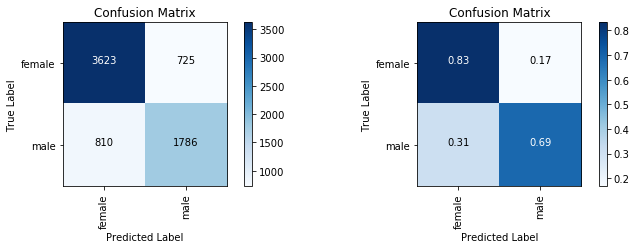

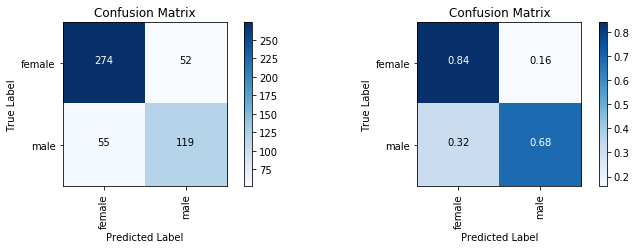

In [848]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb3,train_cm_nb3,train_label_names_nb3,train_report_nb3, \
    devtest_accuracy_nb3, devtest_cm_nb3,devtest_label_names_nb3, \
    devtest_report_nb3, classifier_nb3=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features3)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb3))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb3))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb3,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb3,['female','male'])

In [723]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb3)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb3)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8173    0.8333    0.8252      4348
       male     0.7113    0.6880    0.6994      2596

avg / total     0.7776    0.7789    0.7782      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8328    0.8405    0.8366       326
       male     0.6959    0.6839    0.6899       174

avg / total     0.7852    0.7860    0.7856       500



In [724]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb3.show_most_informative_features(n_informative_features)

Most Informative Features
              lastletter = u'k'             male : female =     39.8 : 1.0
              lastletter = u'a'           female : male   =     32.2 : 1.0
              lastletter = u'f'             male : female =     15.0 : 1.0
              lastletter = u'v'             male : female =     11.0 : 1.0
              lastletter = u'd'             male : female =      9.8 : 1.0
              lastletter = u'm'             male : female =      9.8 : 1.0
              lastletter = u'p'             male : female =      9.7 : 1.0
                count(v) = 2              female : male   =      8.6 : 1.0
              lastletter = u'o'             male : female =      8.2 : 1.0
              lastletter = u'r'             male : female =      6.6 : 1.0


#### Gender Classification Model 4

In this model, we train a Naive Bayes classifier using the last letter of the name and the last two letters of a name.

Accuracy (Train): 0.78801843318
Accuracy (Development Test): 0.786


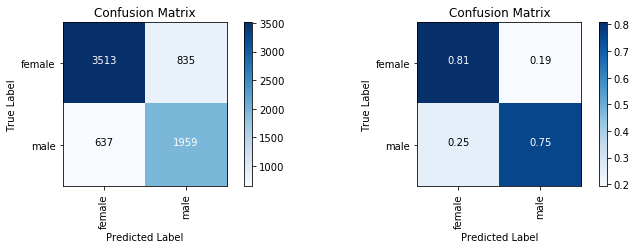

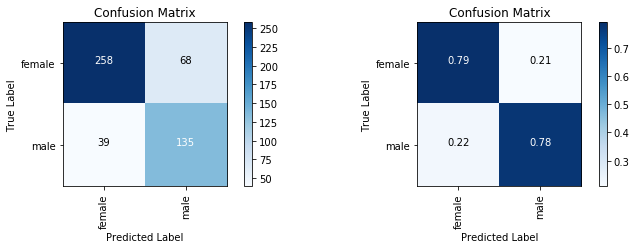

In [849]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb4,train_cm_nb4,train_label_names_nb4,train_report_nb4, \
    devtest_accuracy_nb4, devtest_cm_nb4,devtest_label_names_nb4, \
    devtest_report_nb4, classifier_nb4=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features4)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb4))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb4))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb4,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb4,['female','male'])

In [726]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb4)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb4)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8465    0.8080    0.8268      4348
       male     0.7011    0.7546    0.7269      2596

avg / total     0.7922    0.7880    0.7894      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8687    0.7914    0.8283       326
       male     0.6650    0.7759    0.7162       174

avg / total     0.7978    0.7860    0.7893       500



In [727]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb4.show_most_informative_features(n_informative_features)

Most Informative Features
             last2letter = u'na'          female : male   =     93.5 : 1.0
             last2letter = u'la'          female : male   =     69.7 : 1.0
              lastletter = u'k'             male : female =     39.8 : 1.0
             last2letter = u'ia'          female : male   =     38.9 : 1.0
             last2letter = u'ra'          female : male   =     34.0 : 1.0
             last2letter = u'sa'          female : male   =     33.9 : 1.0
              lastletter = u'a'           female : male   =     32.2 : 1.0
             last2letter = u'rt'            male : female =     28.5 : 1.0
             last2letter = u'us'            male : female =     27.9 : 1.0
             last2letter = u'ld'            male : female =     23.3 : 1.0


#### Gender Classification Model 5

In this model, we train a Naive Bayes classifier using the length of the name.

Accuracy (Train): 0.628744239631
Accuracy (Development Test): 0.66


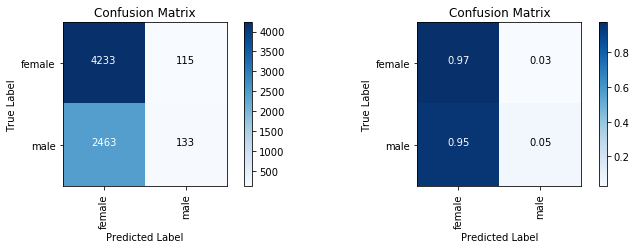

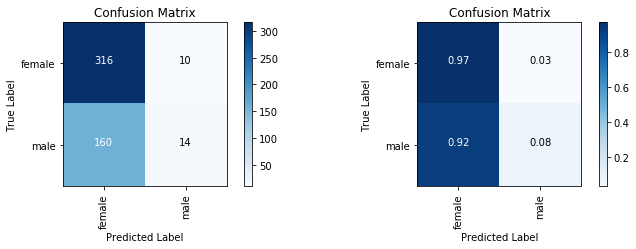

In [850]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb5,train_cm_nb5,train_label_names_nb5,train_report_nb5, \
    devtest_accuracy_nb5, devtest_cm_nb5,devtest_label_names_nb5, \
    devtest_report_nb5, classifier_nb5=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features5)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb5))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb5))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb5,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb5,['female','male'])

In [730]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb5)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb5)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6322    0.9736    0.7666      4348
       male     0.5363    0.0512    0.0935      2596

avg / total     0.5963    0.6287    0.5150      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6639    0.9693    0.7880       326
       male     0.5833    0.0805    0.1414       174

avg / total     0.6358    0.6600    0.5630       500



In [731]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb5.show_most_informative_features(n_informative_features)

Most Informative Features
                  length = 2                male : female =      2.1 : 1.0
                  length = 3                male : female =      1.9 : 1.0
                  length = 15               male : female =      1.7 : 1.0
                  length = 9              female : male   =      1.4 : 1.0
                  length = 10             female : male   =      1.4 : 1.0
                  length = 12               male : female =      1.4 : 1.0
                  length = 4                male : female =      1.2 : 1.0
                  length = 7              female : male   =      1.1 : 1.0
                  length = 8              female : male   =      1.1 : 1.0
                  length = 6                male : female =      1.1 : 1.0


#### Gender Classification Model 6

In this model, we train a Naive Bayes classifier using the letter count.

Accuracy (Train): 0.708093317972
Accuracy (Development Test): 0.712


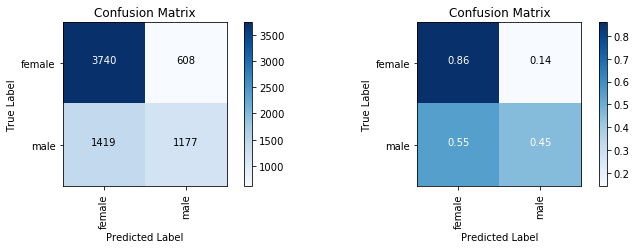

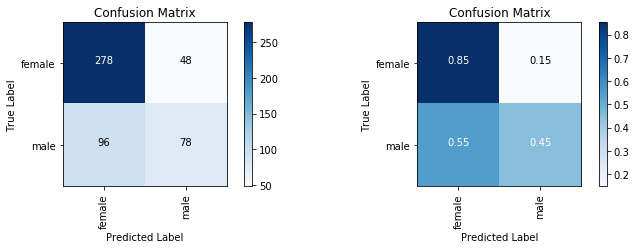

In [851]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb6,train_cm_nb6,train_label_names_nb6,train_report_nb6, \
    devtest_accuracy_nb6, devtest_cm_nb6,devtest_label_names_nb6, \
    devtest_report_nb6, classifier_nb6=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features6)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb6))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb6))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb6,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb6,['female','male'])

In [732]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb6)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb6)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.7249    0.8602    0.7868      4348
       male     0.6594    0.4534    0.5373      2596

avg / total     0.7004    0.7081    0.6935      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7433    0.8528    0.7943       326
       male     0.6190    0.4483    0.5200       174

avg / total     0.7001    0.7120    0.6988       500



In [733]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb6.show_most_informative_features(n_informative_features)

Most Informative Features
                count(v) = 2              female : male   =      8.6 : 1.0
                count(w) = 1                male : female =      4.6 : 1.0
                count(a) = 3              female : male   =      4.5 : 1.0
                count(k) = 2              female : male   =      3.7 : 1.0
                count(o) = 2                male : female =      3.6 : 1.0
                count(f) = 2                male : female =      3.4 : 1.0
                count(l) = 3              female : male   =      3.3 : 1.0
                count(i) = 3                male : female =      3.1 : 1.0
                count(a) = 2              female : male   =      3.0 : 1.0
                count(d) = 3                male : female =      2.8 : 1.0


#### Gender Classification Model 7

In this model, we train a Naive Bayes classifier using the last three letters of the name.

Accuracy (Train): 0.859735023041
Accuracy (Development Test): 0.758


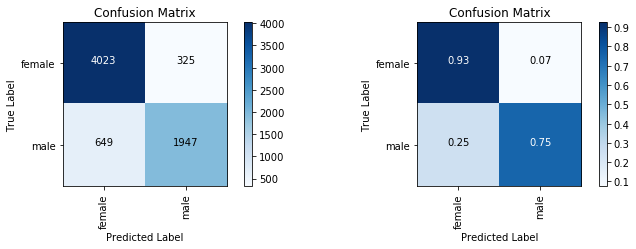

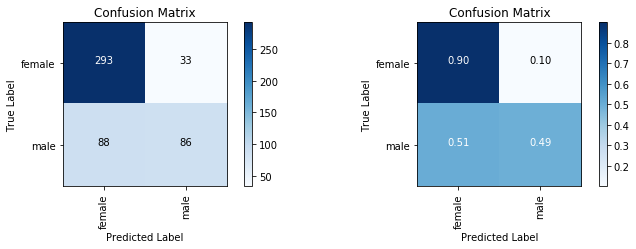

In [852]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb7,train_cm_nb7,train_label_names_nb7,train_report_nb7, \
    devtest_accuracy_nb7, devtest_cm_nb7,devtest_label_names_nb7, \
    devtest_report_nb7, classifier_nb7=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features7)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb7))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb7))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb7,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb7,['female','male'])

In [738]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb7)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb7)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8611    0.9253    0.8920      4348
       male     0.8570    0.7500    0.7999      2596

avg / total     0.8595    0.8597    0.8576      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7690    0.8988    0.8289       326
       male     0.7227    0.4943    0.5870       174

avg / total     0.7529    0.7580    0.7447       500



In [736]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb7.show_most_informative_features(n_informative_features)

Most Informative Features
             last3letter = u'nne'         female : male   =     29.0 : 1.0
             last3letter = u'ana'         female : male   =     23.8 : 1.0
             last3letter = u'tta'         female : male   =     22.9 : 1.0
             last3letter = u'ard'           male : female =     19.9 : 1.0
             last3letter = u'vin'           male : female =     18.9 : 1.0
             last3letter = u'old'           male : female =     16.8 : 1.0
             last3letter = u'ert'           male : female =     15.6 : 1.0
             last3letter = u'ita'         female : male   =     15.0 : 1.0
             last3letter = u'ela'         female : male   =     14.2 : 1.0
             last3letter = u'ria'         female : male   =     12.9 : 1.0


#### Gender Classification Model 8

In this model, we train a Naive Bayes classifier using a feature set composed of all possible two letter combinations.

Accuracy (Train): 0.759648617512
Accuracy (Development Test): 0.76


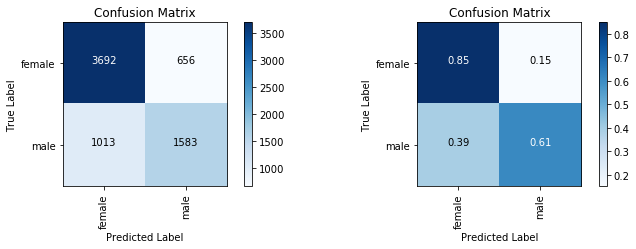

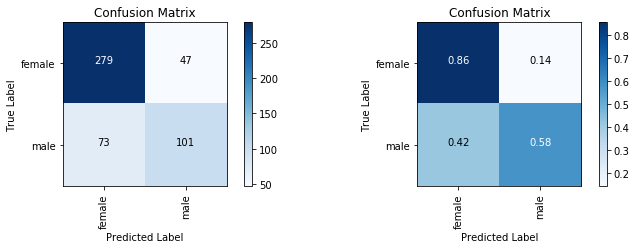

In [853]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb8,train_cm_nb8,train_label_names_nb8,train_report_nb8, \
    devtest_accuracy_nb8, devtest_cm_nb8,devtest_label_names_nb8, \
    devtest_report_nb8, classifier_nb8=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features8)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb8))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb8))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb8,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb8,['female','male'])

In [739]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb8)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb8)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.7847    0.8491    0.8156      4348
       male     0.7070    0.6098    0.6548      2596

avg / total     0.7557    0.7596    0.7555      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7926    0.8558    0.8230       326
       male     0.6824    0.5805    0.6273       174

avg / total     0.7543    0.7600    0.7549       500



In [740]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb8.show_most_informative_features(n_informative_features)

Most Informative Features
                 has(fo) = True             male : female =     34.1 : 1.0
                 has(rk) = True             male : female =     24.0 : 1.0
                 has(hu) = True             male : female =     22.4 : 1.0
                 has(iu) = True             male : female =     17.3 : 1.0
                 has(rw) = True             male : female =     15.1 : 1.0
                 has(sp) = True             male : female =     14.0 : 1.0
                 has(lt) = True             male : female =     13.1 : 1.0
                 has(tc) = True             male : female =     12.8 : 1.0
                 has(wa) = True             male : female =     10.3 : 1.0
                 has(cu) = True             male : female =      9.5 : 1.0


#### Gender Classification Model 9

In this model, we train a Naive Bayes classifier using a feature set comprised of the first two letters of a name.

Accuracy (Train): 0.684907834101
Accuracy (Development Test): 0.672


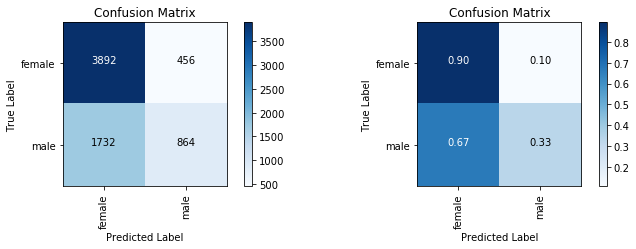

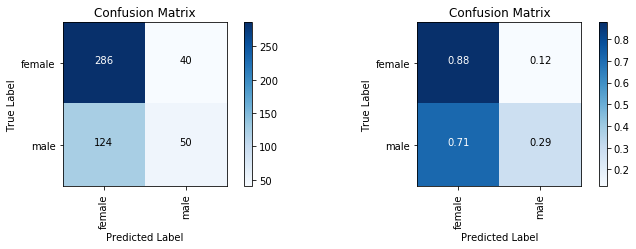

In [854]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb9,train_cm_nb9,train_label_names_nb9,train_report_nb9, \
    devtest_accuracy_nb9, devtest_cm_nb9,devtest_label_names_nb9, \
    devtest_report_nb9, classifier_nb9=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features9)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb9))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb9))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb9,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb9,['female','male'])

In [742]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb9)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb9)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6920    0.8951    0.7806      4348
       male     0.6545    0.3328    0.4413      2596

avg / total     0.6780    0.6849    0.6537      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6976    0.8773    0.7772       326
       male     0.5556    0.2874    0.3788       174

avg / total     0.6481    0.6720    0.6385       500



In [743]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb9.show_most_informative_features(n_informative_features)

Most Informative Features
           first2Letters = u'fo'            male : female =     15.9 : 1.0
           first2Letters = u'hu'            male : female =     13.7 : 1.0
           first2Letters = u'ya'            male : female =     12.6 : 1.0
           first2Letters = u'tu'            male : female =      9.3 : 1.0
           first2Letters = u'wa'            male : female =      8.6 : 1.0
           first2Letters = u'ce'          female : male   =      6.2 : 1.0
           first2Letters = u'ka'          female : male   =      6.1 : 1.0
           first2Letters = u'wh'            male : female =      6.0 : 1.0
           first2Letters = u'we'            male : female =      5.2 : 1.0
           first2Letters = u'fa'          female : male   =      5.1 : 1.0


#### Gender Classification Model 10

In this model, we train a Naive Bayes classifier using a feature set composed the first letter, the last letter, the last two letters, the last 3 letters, the letter count, the presence of a letter, and all two letter combinations.

Accuracy (Train): 0.837269585253
Accuracy (Development Test): 0.824


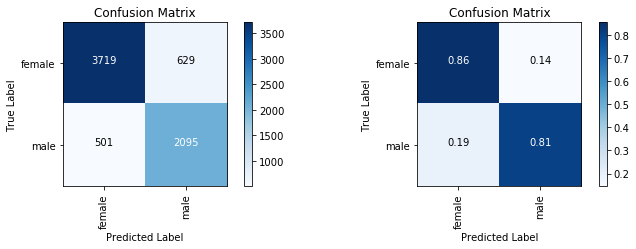

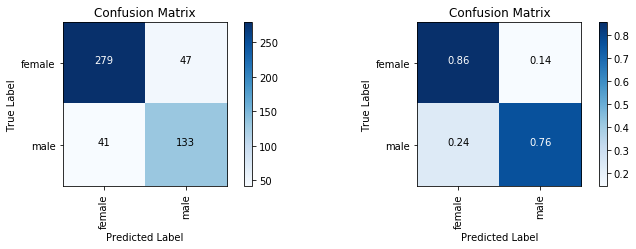

In [855]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb10,train_cm_nb10,train_label_names_nb10,train_report_nb10, \
    devtest_accuracy_nb10, devtest_cm_nb10,devtest_label_names_nb10, \
    devtest_report_nb10, classifier_nb10=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features10)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb10))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb10))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb10,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb10,['female','male'])

In [745]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb10)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb10)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8813    0.8553    0.8681      4348
       male     0.7691    0.8070    0.7876      2596

avg / total     0.8393    0.8373    0.8380      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8719    0.8558    0.8638       326
       male     0.7389    0.7644    0.7514       174

avg / total     0.8256    0.8240    0.8247       500



In [746]:
# set number of informative features to display
n_informative_features=50
# examine likelihood ratios
classifier_nb10.show_most_informative_features(n_informative_features)

Most Informative Features
             last2letter = u'na'          female : male   =     93.4 : 1.0
             last2letter = u'la'          female : male   =     70.0 : 1.0
              lastletter = u'k'             male : female =     39.8 : 1.0
             last2letter = u'ia'          female : male   =     38.9 : 1.0
                 has(fo) = True             male : female =     34.1 : 1.0
             last2letter = u'ra'          female : male   =     34.0 : 1.0
             last2letter = u'sa'          female : male   =     33.9 : 1.0
              lastletter = u'a'           female : male   =     32.2 : 1.0
             last3letter = u'nne'         female : male   =     28.8 : 1.0
             last2letter = u'rt'            male : female =     28.6 : 1.0
             last2letter = u'us'            male : female =     27.9 : 1.0
             last3letter = u'ana'         female : male   =     24.1 : 1.0
                 has(rk) = True             male : female =     24.0 : 1.0

Despite the large feature set, the performance of our model is relatively good on both the training and development test data sets.

#### Gender Classification Model 11

In this model, we train a Naive Bayes classifier using the vowel count.

Accuracy (Train): 0.628456221198
Accuracy (Development Test): 0.658


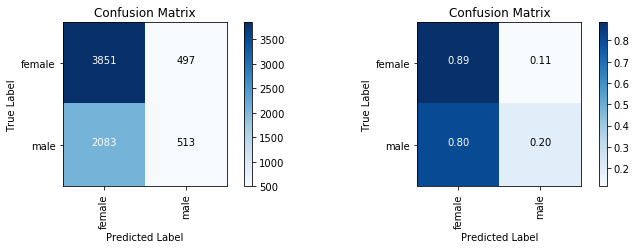

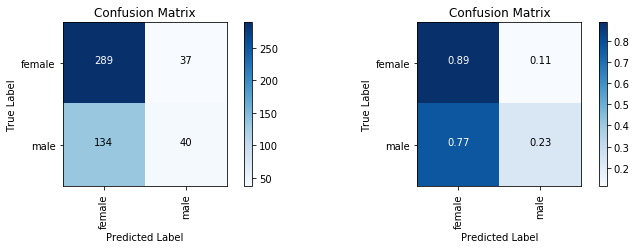

In [856]:
# evaluate the Naive Bayes classifier using gender_features11
train_accuracy_nb11,train_cm_nb11,train_label_names_nb11,train_report_nb11, \
    devtest_accuracy_nb11, devtest_cm_nb11,devtest_label_names_nb11, \
    devtest_report_nb11, classifier_nb11=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features11)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb11))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb11))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb11,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb11,['female','male'])

In [753]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb11)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb11)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6490    0.8857    0.7491      4348
       male     0.5079    0.1976    0.2845      2596

avg / total     0.5962    0.6285    0.5754      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6832    0.8865    0.7717       326
       male     0.5195    0.2299    0.3187       174

avg / total     0.6262    0.6580    0.6141       500



In [756]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb11.show_most_informative_features(n_informative_features)

Most Informative Features
             vowel_count = 5              female : male   =      3.2 : 1.0
             vowel_count = 4              female : male   =      2.5 : 1.0
             vowel_count = 1                male : female =      1.7 : 1.0
             vowel_count = 3              female : male   =      1.5 : 1.0
             vowel_count = 2                male : female =      1.5 : 1.0
             vowel_count = 0                male : female =      1.3 : 1.0


#### Gender Classification Model 12

In this model, we train a Naive Bayes classifier based on hard consonants using general rules of 'c' and 'g'.

Accuracy (Train): 0.626440092166
Accuracy (Development Test): 0.654


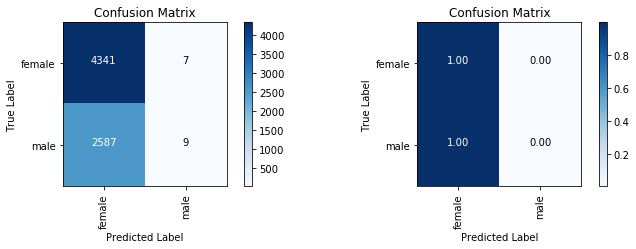

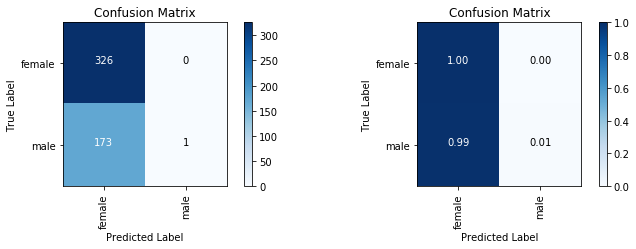

In [857]:
# evaluate the Naive Bayes classifier using gender_features12
train_accuracy_nb12,train_cm_nb12,train_label_names_nb12,train_report_nb12, \
    devtest_accuracy_nb12, devtest_cm_nb12,devtest_label_names_nb12, \
    devtest_report_nb12, classifier_nb12=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features12)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb12))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb12))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb12,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb12,['female','male'])

In [757]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb12)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb12)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6266    0.9984    0.7700      4348
       male     0.5625    0.0035    0.0069      2596

avg / total     0.6026    0.6264    0.4847      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6533    1.0000    0.7903       326
       male     1.0000    0.0057    0.0114       174

avg / total     0.7740    0.6540    0.5193       500



In [758]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb12.show_most_informative_features(n_informative_features)

Most Informative Features
             hard_consts = 1                male : female =      2.1 : 1.0
             hard_consts = 0              female : male   =      1.0 : 1.0


#### Gender Classification Model 13

In this model, we train a Naive Bayes classifier based on soft consonants using general rules of 'c' and 'g'.

Accuracy (Train): 0.626152073733
Accuracy (Development Test): 0.652


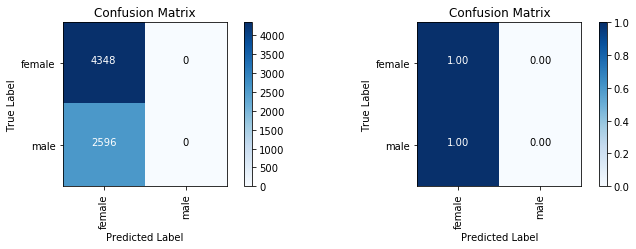

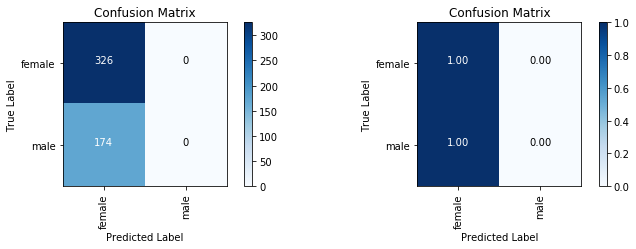

In [858]:
# evaluate the Naive Bayes classifier using gender_features12
train_accuracy_nb13,train_cm_nb13,train_label_names_nb13,train_report_nb13, \
    devtest_accuracy_nb13, devtest_cm_nb13,devtest_label_names_nb13, \
    devtest_report_nb13, classifier_nb13=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features13)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb13))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb13))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb13,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb13,['female','male'])

In [760]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb13)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb13)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6262    1.0000    0.7701      4348
       male     0.0000    0.0000    0.0000      2596

avg / total     0.3921    0.6262    0.4822      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6520    1.0000    0.7893       326
       male     0.0000    0.0000    0.0000       174

avg / total     0.4251    0.6520    0.5147       500



In [761]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb13.show_most_informative_features(n_informative_features)

Most Informative Features
             soft_consts = 1              female : male   =      2.0 : 1.0
             soft_consts = 0                male : female =      1.0 : 1.0


#### Gender Classification Model 14

In this model, we train a Naive Bayes classifier using the syllable count.

Accuracy (Train): 0.626152073733
Accuracy (Development Test): 0.652


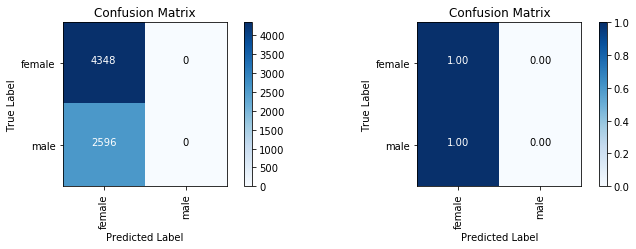

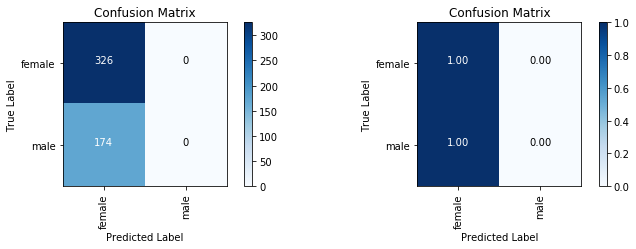

In [859]:
# evaluate the Naive Bayes classifier using gender_features12
train_accuracy_nb14,train_cm_nb14,train_label_names_nb14,train_report_nb14, \
    devtest_accuracy_nb14, devtest_cm_nb14,devtest_label_names_nb14, \
    devtest_report_nb14, classifier_nb14=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,gender_features14)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb14))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb14))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb14,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb14,['female','male'])

In [763]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb14)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb14)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6262    1.0000    0.7701      4348
       male     0.0000    0.0000    0.0000      2596

avg / total     0.3921    0.6262    0.4822      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6520    1.0000    0.7893       326
       male     0.0000    0.0000    0.0000       174

avg / total     0.4251    0.6520    0.5147       500



In [764]:
# set number of informative features to display
n_informative_features=10
# examine likelihood ratios
classifier_nb14.show_most_informative_features(n_informative_features)

Most Informative Features
          syllable_count = 3.6            female : male   =      3.1 : 1.0
          syllable_count = 2.7            female : male   =      2.0 : 1.0
          syllable_count = 0.9              male : female =      1.5 : 1.0
          syllable_count = 1.8              male : female =      1.2 : 1.0


#### Gender Classification Model - Decision Tree 1

In this model, we train a Decision Tree classifier using the last letter of the name.

Accuracy (Train): 0.760512672811
Accuracy (Development Test): 0.764


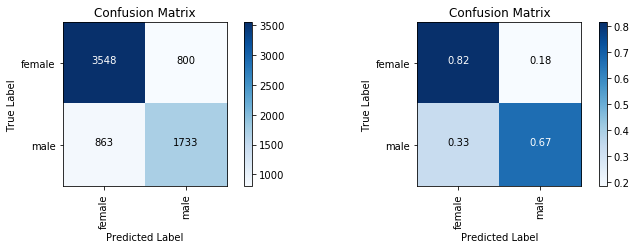

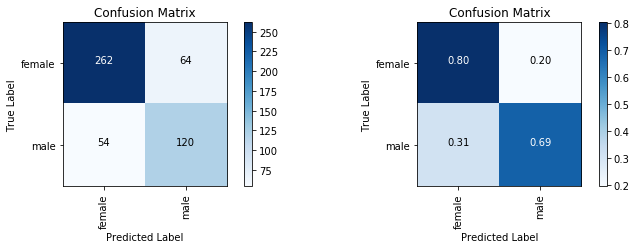

In [860]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt0,train_cm_dt0,train_label_names_dt0,train_report_dt0,devtest_accuracy_dt0, devtest_cm_dt0,devtest_label_names_dt0,devtest_report_dt0, classifier_dt0=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,gender_features)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt0))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt0))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt0,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt0,['female','male'])

In [789]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt0)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt0)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8044    0.8160    0.8101      4348
       male     0.6842    0.6676    0.6758      2596

avg / total     0.7594    0.7605    0.7599      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8291    0.8037    0.8162       326
       male     0.6522    0.6897    0.6704       174

avg / total     0.7675    0.7640    0.7655       500



#### Gender Classification Model - Decision Tree 2

In this model, we train a Decision Tree classifier using the first letter of the name.

Accuracy (Train): 0.646745391705
Accuracy (Development Test): 0.656


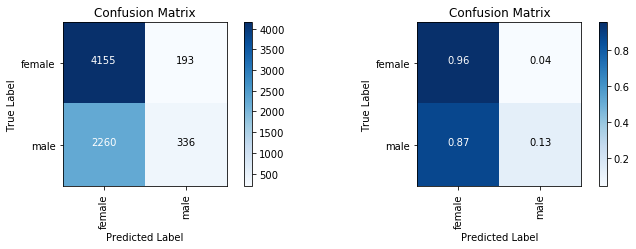

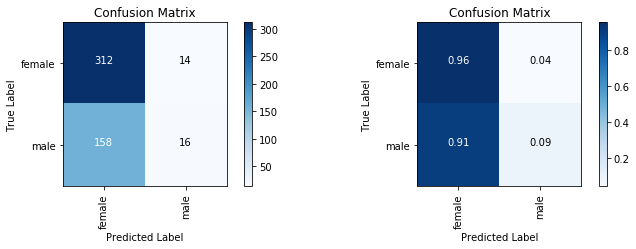

In [861]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt2,train_cm_dt2,train_label_names_dt2,train_report_dt2,devtest_accuracy_dt2, devtest_cm_dt2,devtest_label_names_dt2,devtest_report_dt2,classifier_dt2=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,gender_features2)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt2))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt2))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt2,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt2,['female','male'])

In [790]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt2)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt2)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6477    0.9556    0.7721      4348
       male     0.6352    0.1294    0.2150      2596

avg / total     0.6430    0.6467    0.5638      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6638    0.9571    0.7839       326
       male     0.5333    0.0920    0.1569       174

avg / total     0.6184    0.6560    0.5657       500



#### Gender Classification Model - Decision Tree 3

In this model, we train a Decision Tree classifier using the first and last letter of the name, in addition to letter counts and the presence of a letter.

Accuracy (Train): 0.912298387097
Accuracy (Development Test): 0.808


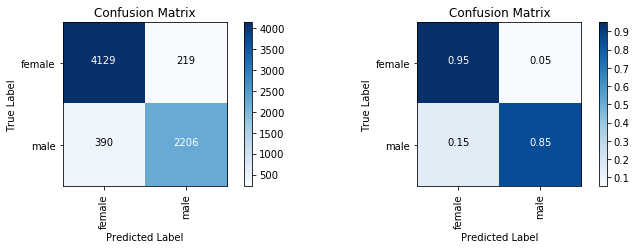

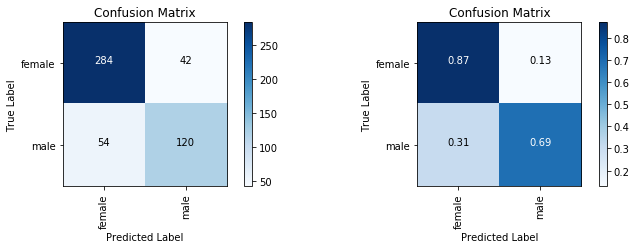

In [862]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt3,train_cm_dt3,train_label_names_dt3,train_report_dt3,devtest_accuracy_dt3, devtest_cm_dt3,devtest_label_names_dt3,devtest_report_dt3, classifier_dt3=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,gender_features3)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt3))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt3))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt3,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt3,['female','male'])

In [787]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt3)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt3)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.9137    0.9496    0.9313      4348
       male     0.9097    0.8498    0.8787      2596

avg / total     0.9122    0.9123    0.9117      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8402    0.8712    0.8554       326
       male     0.7407    0.6897    0.7143       174

avg / total     0.8056    0.8080    0.8063       500



#### Gender Classification Model - Decision Tree 4

In this model, we train a Decision Tree classifier using the last letter of the name and the last two letters of a name.

Accuracy (Train): 0.803139400922
Accuracy (Development Test): 0.788


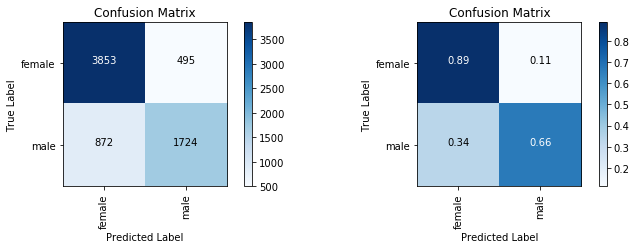

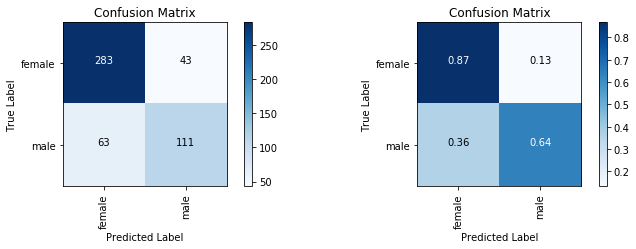

In [863]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt4,train_cm_dt4,train_label_names_dt4,train_report_dt4,devtest_accuracy_dt4, devtest_cm_dt4,devtest_label_names_dt4,devtest_report_dt4, classifier_dt4=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,gender_features4)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt4))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt4))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt4,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt4,['female','male'])

In [786]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt4)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt4)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8154    0.8862    0.8493      4348
       male     0.7769    0.6641    0.7161      2596

avg / total     0.8010    0.8031    0.7995      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8179    0.8681    0.8423       326
       male     0.7208    0.6379    0.6768       174

avg / total     0.7841    0.7880    0.7847       500



#### Gender Classification Model - Decision Tree 5

In this model, we train a Decision Tree classifier using the length of the name.

Accuracy (Train): 0.628744239631
Accuracy (Development Test): 0.66


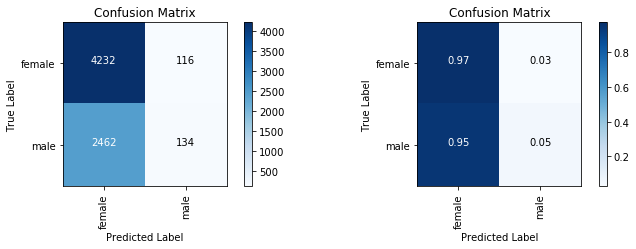

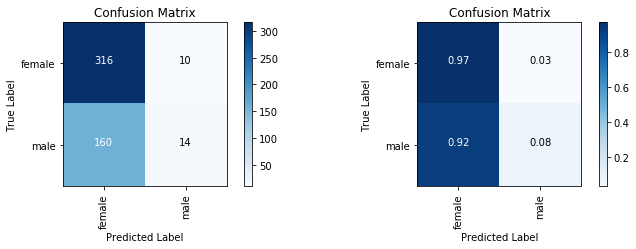

In [864]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt5,train_cm_dt5,train_label_names_dt5,train_report_dt5,devtest_accuracy_dt5, devtest_cm_dt5,devtest_label_names_dt5,devtest_report_dt5, classifier_dt5=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,gender_features5)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt5))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt5))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt5,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt5,['female','male'])

In [785]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt5)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt5)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6322    0.9733    0.7665      4348
       male     0.5360    0.0516    0.0942      2596

avg / total     0.5962    0.6287    0.5152      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6639    0.9693    0.7880       326
       male     0.5833    0.0805    0.1414       174

avg / total     0.6358    0.6600    0.5630       500



#### Gender Classification Model - Decision Tree 6

In this model, we train a Decision Tree classifier using the letter count.

Accuracy (Train): 0.809331797235
Accuracy (Development Test): 0.704


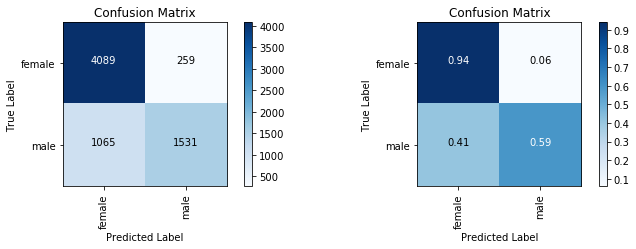

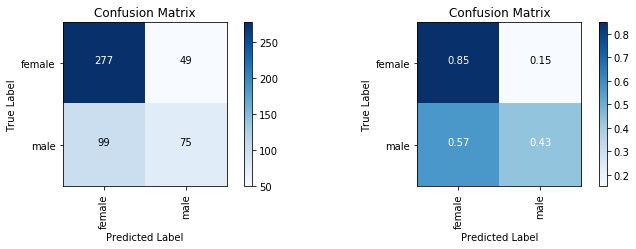

In [865]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt6,train_cm_dt6,train_label_names_dt6,train_report_dt6,devtest_accuracy_dt6, devtest_cm_dt6,devtest_label_names_dt6,devtest_report_dt6, classifier_dt6=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,gender_features6)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt6))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt6))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt6,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt6,['female','male'])

In [784]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt6)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt6)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.7934    0.9404    0.8607      4348
       male     0.8553    0.5898    0.6981      2596

avg / total     0.8165    0.8093    0.7999      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7367    0.8497    0.7892       326
       male     0.6048    0.4310    0.5034       174

avg / total     0.6908    0.7040    0.6897       500



#### Gender Classification Model - Decision Tree 7

In this model, we train a Decision Tree classifier using the last three letters of the name.

Accuracy (Train): 0.859735023041
Accuracy (Development Test): 0.746


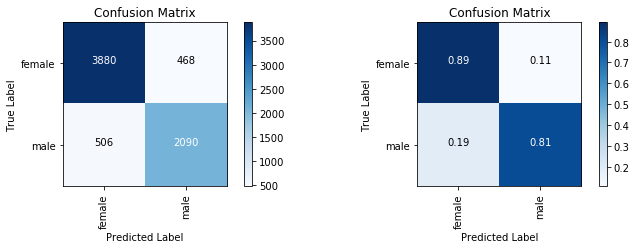

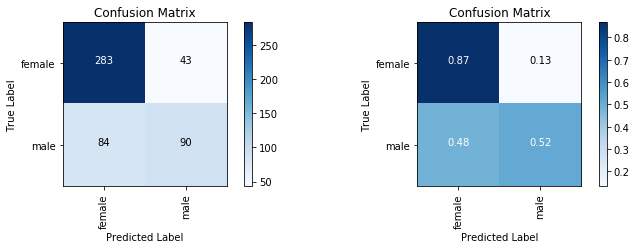

In [866]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt7,train_cm_dt7,train_label_names_dt7,train_report_dt7,devtest_accuracy_dt7, devtest_cm_dt7,devtest_label_names_dt7,devtest_report_dt7, classifier_dt7=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,gender_features7)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt7))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt7))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt7,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt7,['female','male'])

In [791]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt7)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt7)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8846    0.8924    0.8885      4348
       male     0.8170    0.8051    0.8110      2596

avg / total     0.8594    0.8597    0.8595      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7711    0.8681    0.8167       326
       male     0.6767    0.5172    0.5863       174

avg / total     0.7383    0.7460    0.7366       500



#### Gender Classification Model - Decision Tree 8

In this model, we train a Decision Tree classifier using a feature set composed of all possible two letter combinations.

Accuracy (Train): 0.802851382488
Accuracy (Development Test): 0.748


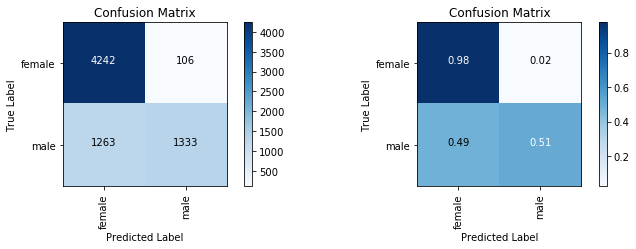

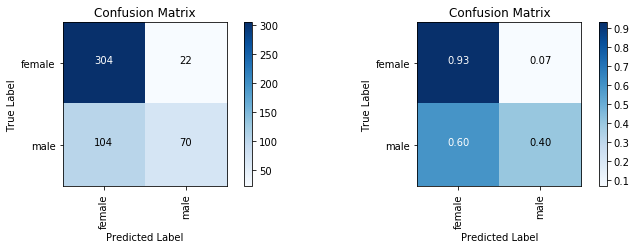

In [867]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt8,train_cm_dt8,train_label_names_dt8,train_report_dt8,devtest_accuracy_dt8, devtest_cm_dt8,devtest_label_names_dt8,devtest_report_dt8, classifier_dt8=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,gender_features8)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt8))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt8))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt8,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt8,['female','male'])

In [783]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt8)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt8)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.7706    0.9756    0.8611      4348
       male     0.9263    0.5135    0.6607      2596

avg / total     0.8288    0.8029    0.7862      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7451    0.9325    0.8283       326
       male     0.7609    0.4023    0.5263       174

avg / total     0.7506    0.7480    0.7232       500



#### Gender Classification Model - Decision Tree 9

In this model, we train a Decision Tree classifier using a feature set comprised of the first two letters of a name.

Accuracy (Train): 0.684907834101
Accuracy (Development Test): 0.676


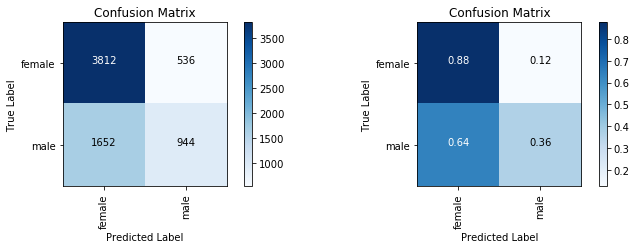

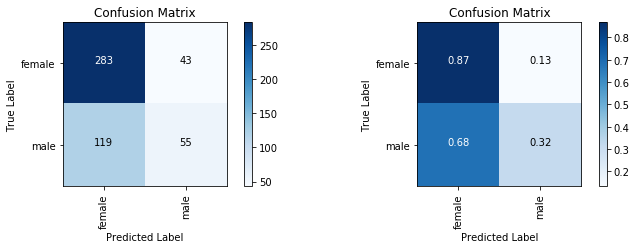

In [868]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt9,train_cm_dt9,train_label_names_dt9,train_report_dt9,devtest_accuracy_dt9, devtest_cm_dt9,devtest_label_names_dt9,devtest_report_dt9, classifier_dt9=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,gender_features9)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt9))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt9))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt9,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt9,['female','male'])

In [782]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt9)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt9)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6977    0.8767    0.7770      4348
       male     0.6378    0.3636    0.4632      2596

avg / total     0.6753    0.6849    0.6597      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7040    0.8681    0.7775       326
       male     0.5612    0.3161    0.4044       174

avg / total     0.6543    0.6760    0.6476       500



#### Gender Classification Model - Decision Tree 10

In this model, we train a Decision Tree classifier using a feature set composed the first letter, the last letter, the last two letters, the last 3 letters, the letter count, the presence of a letter, and all two letter combinations.

Accuracy (Train): 0.953485023041
Accuracy (Development Test): 0.75


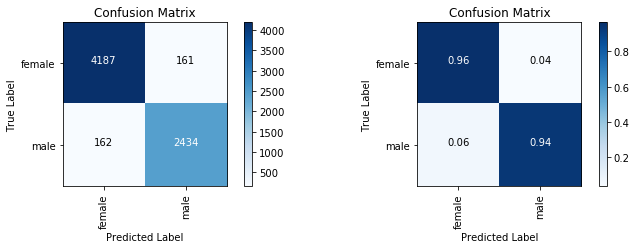

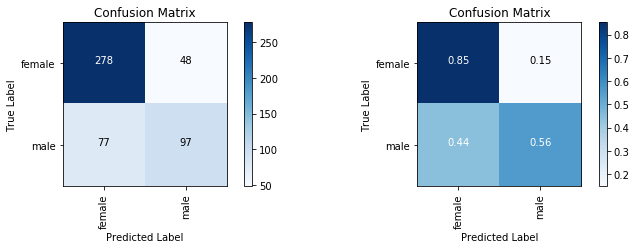

In [869]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt10,train_cm_dt10,train_label_names_dt10,train_report_dt10,devtest_accuracy_dt10, devtest_cm_dt10,devtest_label_names_dt10,devtest_report_dt10, classifier_dt10=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,gender_features10)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt10))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt10))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt10,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt10,['female','male'])

In [713]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt10)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt10)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.9628    0.9630    0.9629      4348
       male     0.9380    0.9376    0.9378      2596

avg / total     0.9535    0.9535    0.9535      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7831    0.8528    0.8164       326
       male     0.6690    0.5575    0.6082       174

avg / total     0.7434    0.7500    0.7440       500



The large difference between the performance on the training and development test data sets is a clear indication of over-fitting. Recall that we generally observed a much smaller difference in the performance between the training and development test sets for Naive Bayes classifiers. This is an expected result. The overall performance of a Naive Bayes classifier can be improved with the inclusion of weak features, while the performance of the Decision Tree classifier cannot by construction.

Accuracy (Train): 0.690236175115
Accuracy (Development Test): 0.69


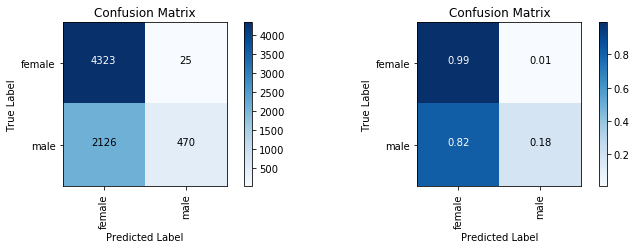

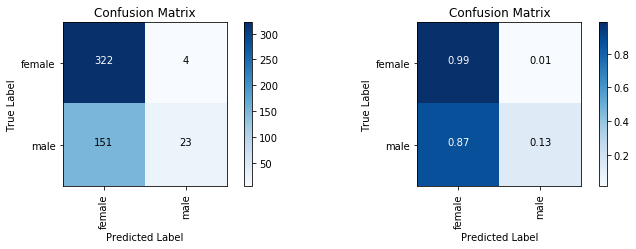

In [870]:
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt_best,train_cm_dt_best,train_label_names_dt_best, \
    train_report_dt_best,devtest_accuracy_dt_best,devtest_cm_dt_best, \
    devtest_label_names_dt_best,devtest_report_dt_best, \
    classifier_dt_best=evaluate_decision_tree_classifier(train_names,
    devtest_names,test_names,best_gender_features)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt_best))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt_best))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt_best,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt_best,['female','male'])

In [770]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt_best)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt_best)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6703    0.9943    0.8008      4348
       male     0.9495    0.1810    0.3041      2596

avg / total     0.7747    0.6902    0.6151      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6808    0.9877    0.8060       326
       male     0.8519    0.1322    0.2289       174

avg / total     0.7403    0.6900    0.6052       500



When we reduce the feature set to a smaller number of features the Decision Tree Classifier, difference in performance between the training and dev is reduced very significantly.

[what about the algorithm creates this difference in behavior]

### Model Selection (Choose Best Candidate) 

#### Check the model's final performance on the test set. 



#### How does the performance on the test set compare to the performance on the dev-test set? 

#### Is this what you'd expect?

In [877]:
# create test set (final test)
test_set = [(gender_features10(n), g)  for (n, g) in test_names]
# extract actual classes (gold)
test_set_gold_nb10 = [g  for (n, g) in test_names]

# create predicted classes (test)
test_set_predictions_nb10 = [classifier_nb10.classify(gender_features10(n))  for (n, g) in test_names]
# compute accuracy (test set)
test_accuracy_nb10=nltk.classify.accuracy(classifier_nb10, test_set)

# create confusion matrix
test_cm_nb10=confusion_matrix(test_set_gold_nb10, test_set_predictions_nb10)
# get unique classes (train)
test_label_names_nb10 =  list(set(test_set_gold_nb10) | set(test_set_predictions_nb10))    
# create table with precision, recall, f1-score, and support
test_report_nb10=classification_report(test_set_gold_nb10, test_set_predictions_nb10,
    digits=display_digits)

Accuracy (Train): 0.837269585253
Accuracy (Development Test): 0.824
Accuracy (Final Test): 0.804


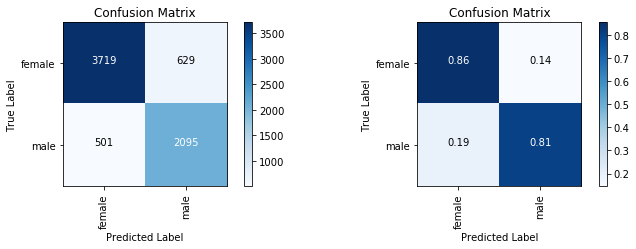

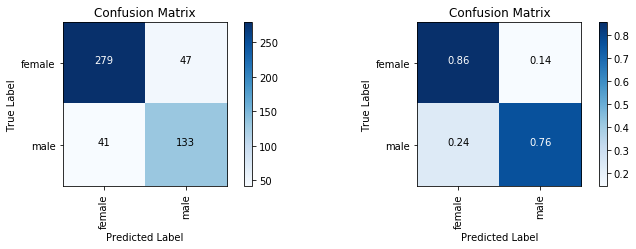

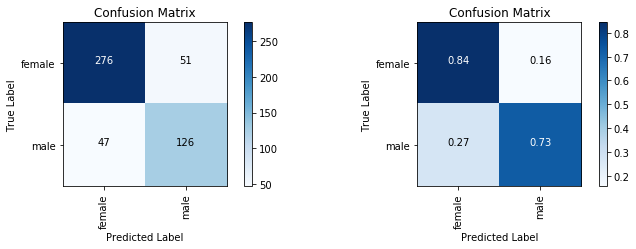

In [878]:
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb10))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb10))
print('Accuracy (Final Test): '+str(test_accuracy_nb10))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb10,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb10,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(test_cm_nb10,['female','male'])

In [879]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb10)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb10)
# display performance report (test)
print('Model Performance Metrics (Test):')
print(test_report_nb10)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8813    0.8553    0.8681      4348
       male     0.7691    0.8070    0.7876      2596

avg / total     0.8393    0.8373    0.8380      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8719    0.8558    0.8638       326
       male     0.7389    0.7644    0.7514       174

avg / total     0.8256    0.8240    0.8247       500

Model Performance Metrics (Test):
             precision    recall  f1-score   support

     female     0.8545    0.8440    0.8492       327
       male     0.7119    0.7283    0.7200       173

avg / total     0.8051    0.8040    0.8045       500



We can see that our model performance degrades on predictions of male names as we move from the training data set to development test data set, then again from the development test data set to the final test data set. The performance degradation is less apparent on female names.

The proportion of female names is roughly the same across the training, development test, and final test data sets (62.6%, 65.2%, and 65.4% respectively). The slightly higher proportion of female names in the development test and final test data sets likely improves our performance marginally.